# IBM Applied Data Science Capstone Project

This notebook shall be mainly used for completing the capstone project.

Feel free to reach me at [@ScientificGhosh](https://twitter.com/ScientificGhosh) on Twitter.

In [1]:
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
import warnings
warnings.filterwarnings("ignore")
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Introduction: Business Undertanding

The Open Data Program makes the data generated by the City of Seattle has been openly available to the public for the purpose of increasing the quality of life for the residents, increasing transparency, accountability and comparability, promoting economic development and research, and improving internal performance management.

The Traffic Records Group, Traffic Management Division, Seattle Department of Transportation, provides data for all collisions and crashes that have occured in the state from 2004 to the present day. The data is updated weekly and can be found at the [Seattle Open GeoData Portal](https://data-seattlecitygis.opendata.arcgis.com/datasets/5b5c745e0f1f48e7a53acec63a0022ab_0?geometry=-122.326%2C47.592%2C-122.318%2C47.594).

The objective is to exploit this data to extract vital features that would enable us to end up with a good model that would enable the prediction of the severity of future accidents that take place in the state. This would further enable the Department of Transportation to prioritise their SOPs and channel their energy to ensure that fewer fatalities result in automobile collisions.

## Data

The dataset is available as comma-separated values (CSV) files, KML files, and ESRI shapefiles that can be downloaded from the Seattle Open GeoData Portal. The data is also available from RESTful API services in formats such as GeoJSON.

### Downloading and Loading the Data

We download the dataset to our project directory and take a look at the data types and the dimensionality of the data. We can see that the dataset contains 221,389 records and 40 fields.

The metadata of the dataset can be found from the website of the [Seattle Department of Transportation](https://www.seattle.gov/Documents/Departments/SDOT/GIS/Collisions_OD.pdf). On reading the dataset summary, we can determine the description of each of the fields and their possible values.

In [3]:
!wget -O data.csv "https://opendata.arcgis.com/datasets/5b5c745e0f1f48e7a53acec63a0022ab_0.csv"

--2020-09-12 16:50:02--  https://opendata.arcgis.com/datasets/5b5c745e0f1f48e7a53acec63a0022ab_0.csv
Resolving opendata.arcgis.com (opendata.arcgis.com)... 54.204.141.17, 50.19.49.12, 34.224.12.157
Connecting to opendata.arcgis.com (opendata.arcgis.com)|54.204.141.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘data.csv’

data.csv                [   <=>              ]  80.99M   143MB/s    in 0.6s    

2020-09-12 16:50:03 (143 MB/s) - ‘data.csv’ saved [84923797]



In [4]:
data = pd.read_csv("data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221389 entries, 0 to 221388
Data columns (total 40 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   X                213918 non-null  float64
 1   Y                213918 non-null  float64
 2   OBJECTID         221389 non-null  int64  
 3   INCKEY           221389 non-null  int64  
 4   COLDETKEY        221389 non-null  int64  
 5   REPORTNO         221389 non-null  object 
 6   STATUS           221389 non-null  object 
 7   ADDRTYPE         217677 non-null  object 
 8   INTKEY           71884 non-null   float64
 9   LOCATION         216801 non-null  object 
 10  EXCEPTRSNCODE    100986 non-null  object 
 11  EXCEPTRSNDESC    11779 non-null   object 
 12  SEVERITYCODE     221388 non-null  object 
 13  SEVERITYDESC     221389 non-null  object 
 14  COLLISIONTYPE    195159 non-null  object 
 15  PERSONCOUNT      221389 non-null  int64  
 16  PEDCOUNT         221389 non-null  int6

The data contains several categorical fields and corresponding descriptions which could help us in further analysis. We make an attempt at understanding the data in terms of the fields that we shall take into account for later stages of model building.

The `X` and `Y` fields denote the longitude and latitude of the collisions. We can visualize the first few non-null collisions on a map.

In [5]:
map = folium.Map(location=[47.60, -122.33], zoom_start=12)
marker_cluster = MarkerCluster().add_to(map)
locations = data[['Y', 'X']][data['Y'].notna()].head(1000)
locationlist = locations.values.tolist()
for point in range(len(locations)):
    folium.Marker(locationlist[point]).add_to(marker_cluster)
map

The `WEATHER` field contains a description of the weather conditions during
the time of the collision. 

In [6]:
data['WEATHER'].value_counts().to_frame('count')

,count
Clear,114694
Raining,34036
Overcast,28543
Unknown,15131
Snowing,919
Other,860
Fog/Smog/Smoke,577
Sleet/Hail/Freezing Rain,116
Blowing Sand/Dirt,56
Severe Crosswind,26


The `ROADCOND` field describes the condition of the road during the collision. 

In [7]:
data['ROADCOND'].value_counts().to_frame('count')

,count
Dry,128535
Wet,48734
Unknown,15139
Ice,1232
Snow/Slush,1014
Other,136
Standing Water,119
Sand/Mud/Dirt,77
Oil,64


The `LIGHTCOND` field describes the light conditions during the collision.

In [8]:
data['LIGHTCOND'].value_counts().to_frame('count')

,count
Daylight,119448
Dark - Street Lights On,50125
Unknown,13532
Dusk,6082
Dawn,2608
Dark - No Street Lights,1579
Dark - Street Lights Off,1239
Other,244
Dark - Unknown Lighting,23


The `SPEEDING` field classifies collisions based on whether or not speeding was a factor in the collision. Blanks indicate cases where the vehicle was not speeding.

In [9]:
data['SPEEDING'].value_counts().to_frame()

,SPEEDING
Y,9928


The `SEVERITYCODE` field contains a code that corresponds to the severity of the
collision. and `SEVERITYDESC` contains a detailed description of the severity of the collision.

We can conclude that there were 349 collisions that resulted in at least one fatality, and 3,102 collisions that resulted in serious injuries. The following table lists the meaning of each of the codes used in the `SEVERITYCODE` field:

| SEVERITYCODE Value | Meaning |
| :-: | --- |
| 1 | Accidents resulting in property damage |
| 2 | Accidents resulting in injuries |
| 2b | Accidents resulting in serious injuries |
| 3 | Accidents resulting in fatalities |
| 0 | Data Unavailable i.e. Blanks |

In [10]:
data['SEVERITYCODE'].value_counts().to_frame('count')

,count
1,137596
2,58747
0,21594
2b,3102
3,349


The `UNDERINFL` field describes whether or not a driver involved was under the
influence of drugs or alcohol. The values `0` and `N` denote that the driver was not under any influence while `1` and `Y` that they were.

In [11]:
data['UNDERINFL'].value_counts().to_frame('count')

,count
N,103874
0,81676
Y,5399
1,4230


The `PERSONCOUNT` and `VEHCOUNT` indicate how many people and vehicles were involved in a collision respectively.

In [12]:
data['PERSONCOUNT'].describe()

count    221389.000000
mean          2.227161
std           1.470190
min           0.000000
25%           2.000000
50%           2.000000
75%           3.000000
max          93.000000
Name: PERSONCOUNT, dtype: float64

In [13]:
data['VEHCOUNT'].describe()

count    221389.000000
mean          1.731057
std           0.829259
min           0.000000
25%           2.000000
50%           2.000000
75%           2.000000
max          15.000000
Name: VEHCOUNT, dtype: float64

As the dataset has possibly been sourced from a database table, several unique identifiers and spatial features are present in the database which may be irrelevant in further statistical analysis. These fields are are `OBJECTID`, `INCKEY`, `COLDETKEY`, `INTKEY`, `SEGLANEKEY`, `CROSSWALKKEY`, and `REPORTNO`. Other fields suchs as `EXCEPTRSNCODE`, `SDOT_COLCODE`, `SDOTCOLNUM` and `LOCATION` and their corresponding descriptions (if any) are categorical but have a large number of distinct values that shall not be that much useful for analysis. The `INCDATE` and `INCDTTM` denote the date and the time of the incident but may not be of use in further analyses. The data needs to be pre-processed.

### Data Pre-processing

Checking for blanks and duplicated records.

In [14]:
data.isna().sum()

X                    7471
Y                    7471
OBJECTID                0
INCKEY                  0
COLDETKEY               0
REPORTNO                0
STATUS                  0
ADDRTYPE             3712
INTKEY             149505
LOCATION             4588
EXCEPTRSNCODE      120403
EXCEPTRSNDESC      209610
SEVERITYCODE            1
SEVERITYDESC            0
COLLISIONTYPE       26230
PERSONCOUNT             0
PEDCOUNT                0
PEDCYLCOUNT             0
VEHCOUNT                0
INJURIES                0
SERIOUSINJURIES         0
FATALITIES              0
INCDATE                 0
INCDTTM                 0
JUNCTIONTYPE        11972
SDOT_COLCODE            1
SDOT_COLDESC            1
INATTENTIONIND     191201
UNDERINFL           26210
WEATHER             26420
ROADCOND            26339
LIGHTCOND           26509
PEDROWNOTGRNT      216197
SDOTCOLNUM          94184
SPEEDING           211461
ST_COLCODE           9413
ST_COLDESC          26230
SEGLANEKEY              0
CROSSWALKKEY

In [15]:
data.duplicated().sum()

0

Selecting relevant fields and dropping others.

In [16]:
data_clean = data[['X', 'Y', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
                   'SPEEDING', 'SEVERITYCODE', 'UNDERINFL',
                   'PERSONCOUNT', 'VEHCOUNT']]
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221389 entries, 0 to 221388
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   X             213918 non-null  float64
 1   Y             213918 non-null  float64
 2   WEATHER       194969 non-null  object 
 3   ROADCOND      195050 non-null  object 
 4   LIGHTCOND     194880 non-null  object 
 5   SPEEDING      9928 non-null    object 
 6   SEVERITYCODE  221388 non-null  object 
 7   UNDERINFL     195179 non-null  object 
 8   PERSONCOUNT   221389 non-null  int64  
 9   VEHCOUNT      221389 non-null  int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 16.9+ MB


Fixing the `SPEEDING` field by encoding it to `0` for the blanks and `1` for the `Y` values.

In [17]:
data_clean['SPEEDING'] = data_clean['SPEEDING'].map({'Y': 1})
data_clean['SPEEDING'].replace(np.nan, 0, inplace=True)
data_clean['SPEEDING'].value_counts().to_frame()

,SPEEDING
0.0,211461
1.0,9928


Records containing values as `Unknown` and `Other` can be considered as null values. Severity Code of 0 corresponds to unknown severity, which can also be treated as null.

In [18]:
data_clean.replace('Unknown', np.nan, inplace=True)
data_clean.replace('Other', np.nan, inplace=True)
data_clean['SEVERITYCODE'].replace('0', np.nan, inplace=True)

We can quickly have an overview of the dataset and look at the frequency of missings records.

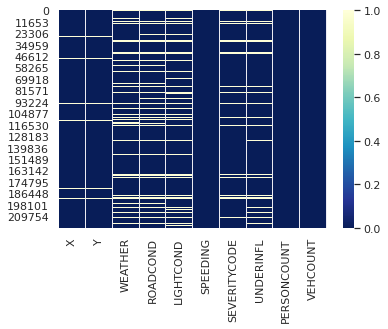

In [19]:
sns.heatmap(data_clean.isnull(), cmap='YlGnBu_r')
plt.show()

We now drop the records having null values in order to clean the data.

In [20]:
data_clean.dropna(axis=0, inplace=True)

Visualizing the dataset after dropping the null values shows that there are no more blanks.

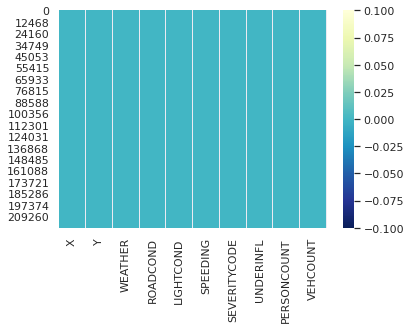

In [21]:
sns.heatmap(data_clean.isnull(), cmap='YlGnBu_r')
plt.show()

As the `UNDERINFL` field had data inconsistency, it is cleaned by converting all `N` and `0` values to `0` and all `Y` and `1` values to `1`.

In [22]:
data_clean['UNDERINFL'] = data_clean['UNDERINFL'].map({'N': 0, '0': 0, 'Y': 1, '1': 1})

In [23]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171380 entries, 0 to 221388
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   X             171380 non-null  float64
 1   Y             171380 non-null  float64
 2   WEATHER       171380 non-null  object 
 3   ROADCOND      171380 non-null  object 
 4   LIGHTCOND     171380 non-null  object 
 5   SPEEDING      171380 non-null  float64
 6   SEVERITYCODE  171380 non-null  object 
 7   UNDERINFL     171380 non-null  int64  
 8   PERSONCOUNT   171380 non-null  int64  
 9   VEHCOUNT      171380 non-null  int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 14.4+ MB


Before encoding the values of the categorical fields, we take a look at their distribution.

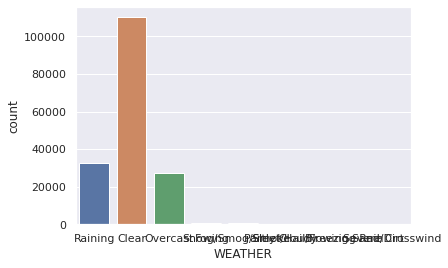

In [24]:
sns.countplot(data_clean['WEATHER'])

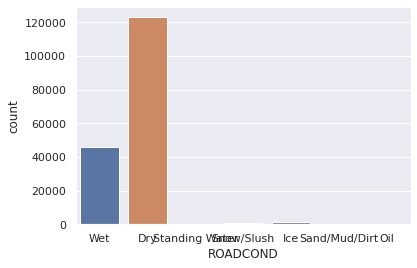

In [25]:
sns.countplot(data_clean['ROADCOND'])

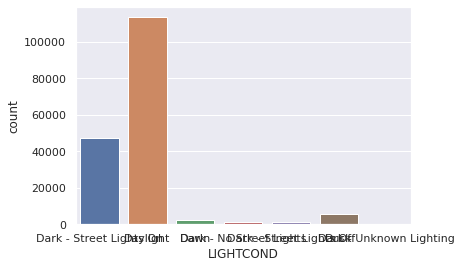

In [26]:
sns.countplot(data_clean['LIGHTCOND'])

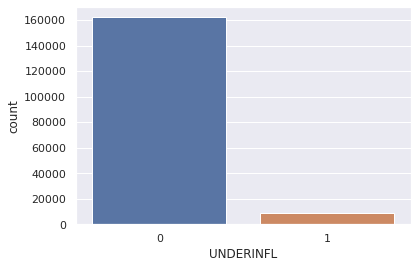

In [27]:
sns.countplot(data_clean['UNDERINFL'])

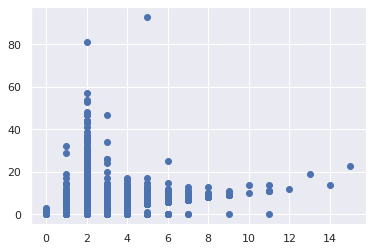

In [28]:
plt.scatter(data_clean['VEHCOUNT'], data_clean['PERSONCOUNT'])

We now do an one-hot encoding of the `WEATHER`, `ROADCOND`, and `LIGHTCOND` fields as they are categorical.

In [29]:
data_clean = pd.concat([data_clean.drop(['WEATHER', 'ROADCOND', 'LIGHTCOND'], axis=1), 
           pd.get_dummies(data_clean['ROADCOND']),
           pd.get_dummies(data_clean['LIGHTCOND']),
           pd.get_dummies(data_clean['WEATHER'])], axis=1)

Shuffling of the dataset is necessary as it is an unbalanced dataset.

In [30]:
data_clean = data_clean.sample(frac=1).reset_index(drop=True)

In [31]:
data_clean.head(5).T

,0,1,2,3,4
X,-122.364,-122.34,-122.338,-122.317,-122.323
Y,47.5537,47.6254,47.6031,47.5535,47.6152
SPEEDING,0,0,0,0,0
SEVERITYCODE,1,1,1,2,2
UNDERINFL,0,0,0,0,0
PERSONCOUNT,2,2,2,3,3
VEHCOUNT,2,2,2,3,2
Dry,1,0,1,1,1
Ice,0,0,0,0,0
Oil,0,0,0,0,0


Correlation is a statistical technique that can show whether and how strongly pairs of variables are related. Finding the correlation among the features of the dataset helps understand the data better. For example, in the heatmap shown below, it can be observed that some features have a strong positive / negative correlation while most of them have weak / no correlation.

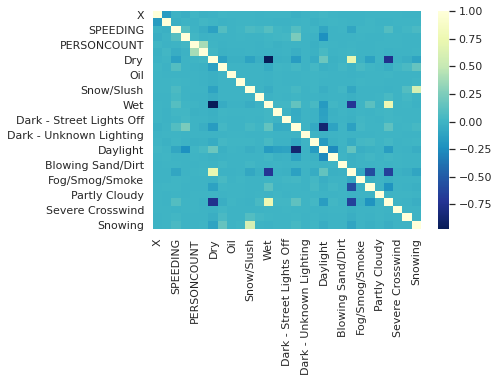

In [32]:
sns.heatmap(data_clean.corr(), cmap='YlGnBu_r')
plt.show()

The datasets `x` and `y` are constructed. The set `x` contains all the training examples and `y` contains all the labels. Feature scaling of data is done to normalize the data in a dataset to a specific range.

After normalization, they are split into `x_train`, `y_train`, `x_test`, and `y_test`. The first two sets sahll be used for training and the last two shall be used for testing. Upon choosing a suitable split ratio, 80% of data is used for training and 20% of is used for testing.

In [33]:
from sklearn import preprocessing
x = data_clean.drop(['SEVERITYCODE'], axis=1)
y = data_clean[['SEVERITYCODE']]
data_clean_scaled = preprocessing.StandardScaler().fit(x).transform(x)
data_clean_scaled[0:3]

array([[-1.136698  , -1.14753579, -0.23626717, -0.23857092, -0.35951016,
         0.0571671 ,  0.62652176, -0.07952372, -0.01691142, -0.01839956,
        -0.06976108, -0.02391978, -0.60748311, -0.08993329, -0.08074068,
        -0.61637295, -0.00996015, -0.12012905,  0.71362769, -0.18554957,
        -0.01565661,  0.74500423, -0.05648197, -0.43418077, -0.00763893,
        -0.48311715, -0.01207874, -0.02522733, -0.06954962],
       [-0.31354893,  0.11463125, -0.23626717, -0.23857092, -0.35951016,
         0.0571671 , -1.59611376, -0.07952372, -0.01691142, -0.01839956,
        -0.06976108, -0.02391978,  1.6461363 , -0.08993329, -0.08074068,
         1.62239436, -0.00996015, -0.12012905, -1.40129092, -0.18554957,
        -0.01565661, -1.34227426, -0.05648197, -0.43418077, -0.00763893,
         2.06989132, -0.01207874, -0.02522733, -0.06954962],
       [-0.2482888 , -0.27870735, -0.23626717, -0.23857092, -0.35951016,
         0.0571671 ,  0.62652176, -0.07952372, -0.01691142, -0.01839956,
  

In [34]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data_clean_scaled, y, 
                                                    test_size=0.2, random_state=42)

### Modelling and Evaluation

Decision Tree makes decision with tree-like model. It splits the sample into two or more homogenous sets (leaves) based on the most significant differentiators in the input variables. To choose a differentiator (predictor), the algorithm considers all features and does a binary split on them (for categorical data, split by category; for continuous, pick a cut-off threshold). It will then choose the one with the least cost (i.e. highest accuracy), and repeats recursively, until it successfully splits the data in all leaves (or reaches the maximum depth).

Information gain for a decision tree classifier can be calculated either using the Gini Index measure or the Entropy measure, whichever gives a greater gain. A hyper parameter Decision Tree Classifier was used to decide which tree to use, DTC using entropy had greater information gain; hence it was used for this classification problem.

In [35]:
from sklearn.tree import DecisionTreeClassifier
dTreeModel = DecisionTreeClassifier(criterion='entropy', max_depth=5)
dTreeModel.fit(x_train, y_train)
dTreeModel

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [36]:
yHat = dTreeModel.predict(x_test)

In [37]:
print(classification_report(y_test, yHat))

              precision    recall  f1-score   support

           1       0.71      0.97      0.82     22462
           2       0.72      0.21      0.33     11140
          2b       0.00      0.00      0.00       599
           3       0.00      0.00      0.00        75

    accuracy                           0.71     34276
   macro avg       0.36      0.30      0.29     34276
weighted avg       0.70      0.71      0.64     34276



Random Forest Classifier is an ensemble (algorithms which combines more than one algorithms of same or different kind for classifying objects) tree-based learning algorithm. RFC is a set of decision trees from randomly selected subset of training set. It aggregates the votes from different decision trees to decide the final class of the test object. Used for both classification and regression.

Similar to DTC, RFT requires an input that specifies a measure that is to be used for classification, along with that a value for the number of estimators (number of decision trees) is required. A hyper parameter RFT was used to determine the best choices for the above mentioned parameters. RFT with 75 DT’s using entropy as the measure gave the best accuracy when trained and tested on pre-processed accident severity dataset.

In [38]:
from sklearn.ensemble import RandomForestClassifier
rfcModel = RandomForestClassifier(n_estimators=75)
rfcModel.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=75,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [39]:
yHat = rfcModel.predict(x_test)

In [40]:
print(classification_report(y_test, yHat))

              precision    recall  f1-score   support

           1       0.72      0.81      0.76     22462
           2       0.49      0.39      0.44     11140
          2b       0.04      0.01      0.02       599
           3       0.05      0.01      0.02        75

    accuracy                           0.66     34276
   macro avg       0.33      0.31      0.31     34276
weighted avg       0.63      0.66      0.64     34276



Logistic Regression is a classifier that estimates discrete values (binary values like 0/1, yes/no, true/false) based on a given set of an independent variables. It basically predicts the probability of occurrence of an event by fitting data to a logistic function. Hence it is also known as logistic regression. The values obtained would always lie within 0 and 1 since it predicts the probability.

The chosen dataset has more than two target categories in terms of the accident severity code assigned, one-vs-one (OvO) strategy is employed.

In [41]:
from sklearn.linear_model import LogisticRegression
logRegModel = LogisticRegression(C=0.01)
logRegModel.fit(x_train, y_train)
logRegModel

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [42]:
yHat = logRegModel.predict(x_test)

In [43]:
print(classification_report(y_test, yHat))

              precision    recall  f1-score   support

           1       0.67      0.97      0.79     22462
           2       0.54      0.09      0.16     11140
          2b       0.00      0.00      0.00       599
           3       0.00      0.00      0.00        75

    accuracy                           0.66     34276
   macro avg       0.30      0.26      0.24     34276
weighted avg       0.61      0.66      0.57     34276



Neural networks can be used to capture non-linearity between features. We have used a Sequential ANN where there are 4 hidden layers. The `relu` and `sigmoid` activation functions are used. The loss function that is used is `categorical_crossentropy` as the target is integer-coded.

In [44]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, input_dim=x_train.shape[1], activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(4, activation='sigmoid')
])

model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

In [45]:
num_epochs = 30
history = model.fit(x_train, tf.keras.utils.to_categorical(
    y_train['SEVERITYCODE'].map({
        '1': 0,
        '2': 1,
        '2b': 2,
        '3': 3
    }), dtype='float32'
), epochs=num_epochs, batch_size=50, validation_split = 0.2)

Epoch 1/30
2194/2194 [==============================] - 4s 2ms/step - loss: 0.6867 - accuracy: 0.6864 - val_loss: 0.6531 - val_accuracy: 0.7056
Epoch 2/30
2194/2194 [==============================] - 3s 2ms/step - loss: 0.6528 - accuracy: 0.7063 - val_loss: 0.6483 - val_accuracy: 0.7072
Epoch 3/30
2194/2194 [==============================] - 4s 2ms/step - loss: 0.6489 - accuracy: 0.7073 - val_loss: 0.6463 - val_accuracy: 0.7101
Epoch 4/30
2194/2194 [==============================] - 4s 2ms/step - loss: 0.6469 - accuracy: 0.7088 - val_loss: 0.6442 - val_accuracy: 0.7125
Epoch 5/30
2194/2194 [==============================] - 4s 2ms/step - loss: 0.6455 - accuracy: 0.7097 - val_loss: 0.6449 - val_accuracy: 0.7099
Epoch 6/30
2194/2194 [==============================] - 4s 2ms/step - loss: 0.6454 - accuracy: 0.7098 - val_loss: 0.6436 - val_accuracy: 0.7117
Epoch 7/30
2194/2194 [==============================] - 4s 2ms/step - loss: 0.6441 - accuracy: 0.7101 - val_loss: 0.6436 - val_accuracy:

In [46]:
yHat = model.predict(x_test)
yPred = [np.argmax(y) for y in yHat]

In [47]:
print(classification_report(y_test.SEVERITYCODE.map({
        '1': 0,
        '2': 1,
        '2b': 2,
        '3': 3
}), yPred))

              precision    recall  f1-score   support

           0       0.71      0.95      0.82     22462
           1       0.67      0.26      0.38     11140
           2       0.00      0.00      0.00       599
           3       0.00      0.00      0.00        75

    accuracy                           0.71     34276
   macro avg       0.35      0.30      0.30     34276
weighted avg       0.69      0.71      0.66     34276



### Results

The accuracies of all models lied in the range 66% to 71% which means we can predict the severity of an accident with that much accuracy. A bar plot is plotted below with the bars representing the accuracy of each model.

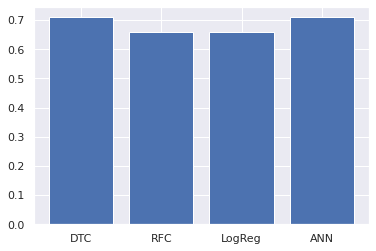

In [48]:
plt.bar(['DTC', 'RFC', 'LogReg', 'ANN'], [0.71, 0.66, 0.66, 0.71])
plt.show()

### Conclusion

The accuracy of the classifiers is not satisfactory, highest being 71%. This usually means that the model is underfitted i.e. it needs to be trained on more data. Though the dataset has a lot of variety in terms of scenarios, more volume of the data for such scenarios has to be collected.

Certain features with missing values were removed, this reduced the dimensionality of the dataset, these features could have been correlated to other important features but they had to be removed. A better effort has to be made to collect data to reduce the number of missing values.

### Future Work

As mentioned above, the amount of data available to train the above mentioned models in not sufficient and it does not seem to have enough data of all varieties. Hence, integrating cross-validation methods with hyper parameter tuning would help in training and possibly increase the accuracy of the classification model.